# Task 1 Solutions

Author: Luis Denninger

## Imports and Initialization

In [1]:
import os
from pathlib import Path as P

import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as fun
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import torch.utils.data as data_utils

import torchvision as tv

import matplotlib.pyplot as plt

import yaml

import copy

from tqdm import tqdm

import optuna

# Import project
import experiments
import models
import src
import utils


## Hyperparameters

In [2]:

MODEL_CONFIG = {
                    'input_dim': 1024,
                    'layers': [518, 128, 64, 32],
                    'output_dim': 10,
                    'dropout': False,
                    'activation': 'relu',
                    'batch_size': 64,
                    'num_epochs': 20,
                    'learning_rate': 0.0001,
                    'random_seed': 42,
                    'pre_processing': {
                        'flatten': True,
                        'flatten_only_img_size': True,
                        'rgb2gray': True,
                        'lbl_oneHot': True,
                        'squeeze': True
                    },
                    'evaluation': {
                        'metrics': ['accuracy', 'precision', 'precision_per_class', 'recall', 'recall_per_class'],
                        'classes': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
                    },
                    'dataset': {
                            'name': 'svhn',
                            'train_size': 73257,
                            'val_size': 6000,
                            'test_size': 26032,
                            'train_shuffle': True,
                            'eval_shuffle': False,
                            'drop_last': True,
                            'classes': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
                    }

}


In [3]:
def set_random_seed(seed):
    np.random.seed(seed)
    torch.manual_seed(seed)

set_random_seed(MODEL_CONFIG['random_seed'])

## Data Loading

In [4]:
train_dataset = datasets.SVHN(root='./data/svhn', split='train', transform=transforms.ToTensor(), download=True)
val_dataset = datasets.SVHN(root='./data/svhn', split='extra', transform=transforms.ToTensor(), download=True)
test_dataset = datasets.SVHN(root='./data/svhn', split='test', transform=transforms.ToTensor(), download=True)


def load_data(config, train=True):
    train_loader = torch.utils.data.DataLoader(train_dataset if train else val_dataset, batch_size=config['batch_size'], shuffle=True, drop_last=True)
    test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=config['batch_size'], shuffle=False, drop_last=True)
    return train_loader, test_loader

train_loader, test_loader = load_data(MODEL_CONFIG)
print('\n')
print(f'Train dataset size: {len(train_dataset)}')
print(f'Test dataset size: {len(test_dataset)}')

TRAIN_SET_SIZE = 73257
TEST_SET_SIZE = 26032

Using downloaded and verified file: ./data/svhn/train_32x32.mat
Using downloaded and verified file: ./data/svhn/extra_32x32.mat
Using downloaded and verified file: ./data/svhn/test_32x32.mat


Train dataset size: 73257
Test dataset size: 26032


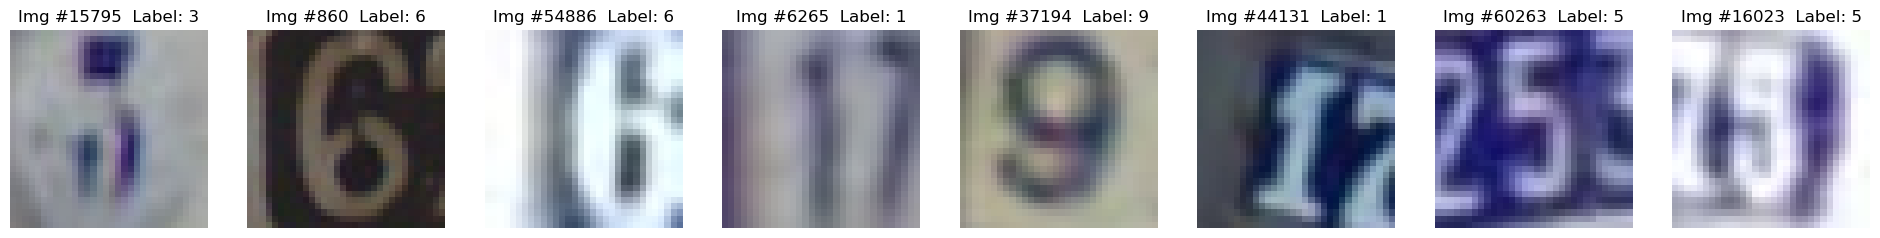

In [5]:
###--- Visualize Training Images ---###

NUM_IMG = 8

fig, ax = plt.subplots(1,NUM_IMG)
fig.set_size_inches(3 * NUM_IMG, 3)

ids = np.random.randint(low=0, high=len(train_dataset), size=NUM_IMG)

for i, n in enumerate(ids):
    img = train_dataset[n][0].permute(1,2,0)
    label = train_dataset[n][1]
    ax[i].imshow(img)
    ax[i].set_title(f"Img #{n}  Label: {label}")
    ax[i].axis("off")


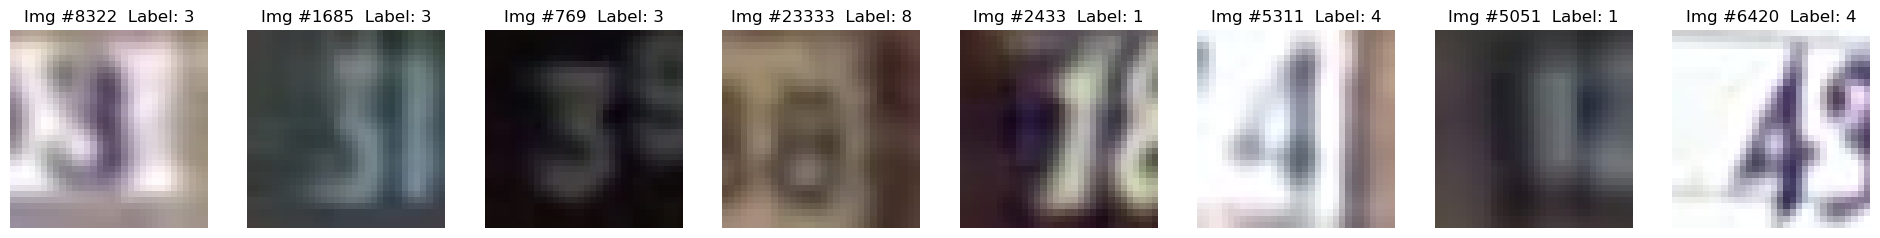

In [6]:
###--- Visualize Evaluation Images ---###

NUM_IMG = 8

fig, ax = plt.subplots(1,NUM_IMG)
fig.set_size_inches(3 * NUM_IMG, 3)

ids = np.random.randint(low=0, high=len(test_dataset), size=NUM_IMG)

for i, n in enumerate(ids):
    img = test_dataset[n][0].permute(1,2,0)
    label = test_dataset[n][1]
    ax[i].imshow(img)
    ax[i].set_title(f"Img #{n}  Label: {label}")
    ax[i].axis("off")

## Multi-Layer Perceptron

In [7]:
class MLP_Classifier(nn.Module):

    def __init__(self,
                    input_dim: int,
                    mlp_layers: list,
                    ):
        """
        Initialization of a multi-layer perceptron.

        Parameters:
            input_dim (int): Size of the input.
            mlp_layers (list): List containing the sizes and types of the mlp layers. Number of elements determines the number of layers.
                Format: 
                    [
                        {
                            'type': 'linear',
                            'activation':'relu',
                            'dimension': 128
                        },
                        {
                            'type': 'batchnorm',
                            'eps':1e-5,
                            'momentum': 0.1
                        },
                        {
                            'type': 'dropout',
                            'prob': 0.5
                        }
                    ]
            output_dim (int): Size of the output.
        """
        
        super(MLP_Classifier, self).__init__()
        self.build_up_model(input_dim, mlp_layers)

    def build_up_model(self, input_dim: int, mlp_layers: list):
        # Build the model and each layer according to the config
        layers = nn.ModuleList()
        for (i, layer) in enumerate(mlp_layers):
            layer_inp_dim = input_dim if i == 0 else mlp_layers[i-1]['dimension']
            # Add a linear layer with a given activation function
            if layer['type'] == 'linear':
                layers.append(nn.Linear(layer_inp_dim, layer['dimension']))
                if layer['activation'] is not None:
                    if layer['activation'] =='relu':
                        layers.append(nn.ReLU())
                    if layer['activation'] == 'tanh':
                        layers.append(nn.Tanh())
                    if layer['activation'] =='sigmoid':
                        layers.append(nn.Sigmoid())
                    if layer['activation'] == 'elu':
                        layers.append(nn.ELU())
                    if layer['activation'] =='selu':
                        layers.append(nn.SELU())
                    if layer['activation'] == 'leaky_relu':
                        layers.append(nn.LeakyReLU())
                    if layer['activation'] == 'prelu':
                        layers.append(nn.PReLU())
                    if layer['activation'] == 'softmax':
                        layers.append(nn.Softmax(dim=-1))
            if layer['type'] =='batchnorm':
                layers.append(nn.BatchNorm1d(layer_inp_dim, layer['eps'], layer['momentum']))
            if layer['type'] == 'dropout':
                layers.append(nn.Dropout(layer['prob']))
            
        self.model = nn.Sequential(*layers)
            

    
    def forward(self, x):
        return self.model(x)
    

def build_model(config: dict):
    # Build the model from the given config
    # Since the above model was taken from a broader framework that has more flexibility, we have to convert our simpler config file
    layer_config = []
    for layer in config['layers']:
        # Add each layer
        layer_config.append({
            'type': 'linear',
            'activation': config['activation'],
            'dimension': layer})
        # Add dropout layers in between if wanted
        if config['dropout']:
            layer_config.append({
                'type': 'dropout',
                'prob': 0.5})
    # Append final output layer
    layer_config.append({'type': 'linear',
            'activation': 'softmax',
            'dimension': config['output_dim']})
    
    model = MLP_Classifier(config['input_dim'], layer_config)

    return model

## Helper Functions

In [8]:




###--- Helper Functions ---###
##---> The following functions are copy+paste from the framework
##---> They are just here to make our life easier
def initialize_optimizer(model: torch.nn.Module, config: dict):
    """
        Initialize optimizer.

        Arguments:
            model (torch.nn.Module): Model to be optimized.
            config (dict): Optimizer configuration dictionary.
                Format:
                        {
                            'type': 'Adam',
                            'learning_rate': Learning rate (float),
                            'betas': Betas (tuple of floats),
                            'eps': Epsilon (float),
                        }
    """
    optimizer = torch.optim.Adam(model.parameters(), lr=config['learning_rate'])
        
    return optimizer

def initialize_loss( config: dict):
    """
        Initialize criterion.

        Arguments:
            config (dict): Criterion configuration dictionary.
                Format:
                        {
                            'type': 'CrossEntropyLoss',
                        }
    """
    criterion = torch.nn.CrossEntropyLoss()

    return criterion

####---- Data Preprocessing ----####

def apply_data_preprocessing(images: torch.Tensor, labels: torch.tensor, config: dict):
    """
    Apply data preprocessing to images and labels.

    Arguments:
        images (torch.Tensor): Images to be preprocessed.
        labels (torch.tensor): Labels to be preprocessed.
        config (dict): Pre-processing configuration dictionary.
            Format:
                    {
                        'flatten': Flatten image (bool),
                        'flatten_only_img_size': Only flatten the height and width dimensions (bool),
                        'rgb2gray': Convert RGB to grayscale (bool),
                        'lbl_oneHot': Convert labels to one-hot format (bool),
                        'squeeze': Squeeze singleton dimensions of the image (bool),
                    }
    """
    images_proc = images.clone()
    labels_proc = labels.clone()

    if config['pre_processing']['rgb2gray']:
        images_proc = _rgb2grayscale(images_proc)

    if config['pre_processing']['flatten']:
        images_proc = _flatten_img(images_proc, only_img_size=config['pre_processing']['flatten_only_img_size'])
    
    if config['pre_processing']['lbl_oneHot']:
        labels_proc = _one_hot_encoding(labels_proc, num_classes=len(config['dataset']['classes']))
    
    if config['pre_processing']['squeeze']:
        images_proc = images_proc.squeeze()

    return images_proc, labels_proc
## Processing Functions ##    

def _flatten_img(input: torch.Tensor, only_img_size: bool=True):
    # Flatten only the image size dimensions

    if only_img_size:
        return torch.flatten(input, start_dim=-2)
   
    # Flatten all dimensions except of the batch dimension
    else:
        return torch.flatten(input, start_dim=1)

def _rgb2grayscale(input: torch.Tensor):
    return tv.transforms.Grayscale()(input)

def _one_hot_encoding(labels: torch.tensor, num_classes: int):
    return fun.one_hot(labels, num_classes=num_classes).float()

## Evaluation

In [14]:
###--- Evaluation Scripts ---###

def run_evaluation( model: torch.nn.Module, 
                    dataset: torch.utils.data.DataLoader, 
                    config: dict,
                    suppress_output: bool = False):
    """
        Runs evaluation of the given model on the given dataset.

        Arguments:
            model (torch.nn.Module): The model to evaluate.
            dataloader (torch.utils.data.DataLoader): The dataloader to evaluate on.
            config (dict): The configuration dictionary.
            device (str, optional): The device to evaluate on. Defaults to "cpu".

    """
    
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    
    # Setup model for evaluation
    model.eval()
    model.to(device)

    eval_metrics = {}

    with torch.no_grad():
        if suppress_output:
            progress_bar = enumerate(dataset)
        else:
            progress_bar = tqdm(enumerate(dataset), total=len(dataset))
            progress_bar.set_description(f'Evaluation:')
        outputs = []
        targets = []
        for i, (imgs, labels) in progress_bar:
            
            labels_raw = torch.clone(labels)
            imgs, labels = imgs.to(device), labels.to(device)

            imgs, labels = apply_data_preprocessing(imgs, labels, config)

            imgs, labels = imgs.float(), labels.float()

            output = model(imgs).float()

            outputs.append(output.cpu())
            targets.append(labels_raw.cpu())
        
        for eval_metric in config['evaluation']['metrics']:
            func_name = '_evaluation_' + eval_metric
            try:
                eval_metrics[eval_metric] = globals()[func_name](torch.stack(outputs, dim=0), torch.stack(targets, dim=0), config)
            except:
                print(f"NotImplemented: Evaluation metric {eval_metric}")
    return eval_metrics

    
## Evaluation Metrics ##

def _evaluation_accuracy(output: torch.Tensor, target: torch.Tensor, config: dict) -> list:
    """
        Computes the accuracy of the the predictions given the target.

        Arguments:
            output (torch.Tensor): The output of the model.
            target (torch.Tensor): The target of the model.

        Returns:
            float: The accuracy of the given model on the given dataset.
    """

    _, predicted = torch.max(output, -1)

    if len(predicted.shape)==2 and len(target.shape)==2:
        predicted = torch.flatten(predicted)
        target = torch.flatten(target)

        total = target.shape[0]
    correct = (predicted == target).sum().item()

    return [correct / total]

def _evaluation_precision(output: torch.Tensor, target: torch.Tensor, config: dict) -> list:
    """
        Computes the precision of the the predictions given the target.

        Arguments:
            output (torch.Tensor): The output of the model.
            target (torch.Tensor): The target of the model.

        Returns:
            float: The precision of the given model on the given dataset.
    """
    assert 'classes' in config['evaluation']
    
    # Discrete set of classes for the classification task
    CLASSES = config['evaluation']['classes']
    _, predicted = torch.max(output.data, -1)

    if len(predicted.shape)==2 and len(target.shape)==2:
        predicted = torch.flatten(predicted)
        target = torch.flatten(target)

    class_precision = []

    for label in CLASSES:
        tp = ( (predicted == label) and (target == label) ).sum().item()
        fp = ( (predicted == label) and (target!= label) ).sum().item()
        class_precision.append(tp / (tp + fp))

    return [sum(class_precision) / len(class_precision)]

def _evaluation_precision_per_class(output: torch.Tensor, target: torch.Tensor, config: dict) -> list:
    """
        Computes the precision of the the predictions given the target for each class separately.

        Arguments:
            output (torch.Tensor): The output of the model.
            target (torch.Tensor): The target of the model.

        Returns:
            float: The precision of the given model on the given dataset.
    """
    assert 'classes' in config['evaluation']
    
    # Discrete set of classes for the classification task
    CLASSES = config['evaluation']['classes']
    _, predicted = torch.max(output.data, -1)

    if len(predicted.shape)==2 and len(target.shape)==2:
        predicted = torch.flatten(predicted)
        target = torch.flatten(target)

    class_precision = []

    for label in CLASSES:
        tp = ( (predicted == label) and (target == label) ).sum().item()
        fp = ( (predicted == label) and (target!= label) ).sum().item()
        class_precision.append(tp / (tp + fp))

    return class_precision


def _evaluation_recall(output: torch.Tensor, target: torch.Tensor, config: dict) -> list:
    """
        Computes the recall of the the predictions given the target.

        Arguments:
            output (torch.Tensor): The output of the model.
            target (torch.Tensor): The target of the model.

        Returns:
            float: The recall of the given model on the given dataset.
    """
    assert 'classes' in config['evaluation']
    
    # Discrete set of classes for the classification task
    CLASSES = config['evaluation']['classes']
    _, predicted = torch.max(output.data, 1)

    if len(predicted.shape)==2 and len(target.shape)==2:
        predicted = torch.flatten(predicted)
        target = torch.flatten(target)

    class_recall = []

    for label in CLASSES:
        tp = ((predicted == label) and (target == label) ).sum().item()
        fn = ( (predicted != label) and (target == label) ).sum().item()
        class_recall.append(tp / (tp + fn))

    return sum(class_recall) / len(class_recall)

def _evaluation_recall_per_class(output: torch.Tensor, target: torch.Tensor, config: dict) -> list:
    """
        Computes the recall of the the predictions given the target for each class separately.

        Arguments:
            output (torch.Tensor): The output of the model.
            target (torch.Tensor): The target of the model.

        Returns:
            float: The recall of the given model on the given dataset.
    """
    assert 'classes' in config['evaluation']
    
    # Discrete set of classes for the classification task
    CLASSES = config['evaluation']['classes']
    _, predicted = torch.max(output.data, 1)

    if len(predicted.shape)==2 and len(target.shape)==2:
        predicted = torch.flatten(predicted)
        target = torch.flatten(target)

    class_recall = []

    for label in CLASSES:
        tp = ((predicted == label) and (target == label) ).sum().item()
        fn = ( (predicted!= label) and (target == label) ).sum().item()
        class_recall.append(tp / (tp + fn))

    return class_recall


## Training

In [15]:
###--- Training Scripts ---###

def train_evaluate_model(   model: nn.Module, 
                            config: dict,
                            train_loader: torch.utils.data.DataLoader,
                            test_loader: torch.utils.data.DataLoader,
                            optimizer: torch.optim.Optimizer, 
                            criterion: nn.Module, 
                            trial: optuna.trial.FrozenTrial = None,
                            suppress_output: bool = False
                            ):
    
    def __run_epoch():
        if suppress_output:
            dataset_iterator = enumerate(train_loader)
        else:
            dataset_iterator = tqdm(enumerate(train_loader), total=len(train_loader))
        for i, (imgs, labels) in dataset_iterator:
            # Prepare inputs
            imgs = imgs.to(device)
            labels = labels.to(device)
            imgs, labels = apply_data_preprocessing(imgs, labels, config)
            # Produce output
            output = model(imgs)
            # Compute loss and backpropagate
            loss = criterion(output, labels)
            optimizer.zero_grad()
            loss.backward()
            # Finally update all weights
            optimizer.step()
            losses.append(loss.item())
            if not suppress_output:
                dataset_iterator.set_description(f'Loss: {loss.item():.4f}')

    ###----Training----###
    EPOCHS = config["num_epochs"]

    # Set device
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    # Train the model
    eval_score_epoch = []
    losses = []

    # Iterate for 'num_epochs' epochs
    for epoch in range(EPOCHS):
        __run_epoch()
        eval_score_epoch.append(list(run_evaluation(model=model, dataset=test_loader, config=config).values())[0][0])
        # Pruning
        if trial is not None:
            trial.report(eval_score_epoch[-1], step=epoch)
            if trial.should_prune():
                raise optuna.exceptions.TrialPruned()
    return sum(eval_score_epoch) / EPOCHS

## Hyperparameter Tuning


### Architecture Studies

In [16]:
## Configuration of the Study
N_TRIALS = 2

N_LAYERS = 5
LAYER_SIZES = [[4, 518], [4, 518], [4, 518], [4, 518], [4, 518]]

OPT_CONFIG = copy.deepcopy(MODEL_CONFIG)


## Objective Function ##

def arch_objective(trial):
        """
            Objective function for hyperparameter optimization.

            Arguments:
                trial (optuna.trial.FrozenTrial): The trial to optimize.

            Returns:
                float: The objective value of the trial.
        """
        # Set trial from trial config
        set_random_seed(OPT_CONFIG['random_seed'])

        # Set optimization parameter
        n_layers = trial.suggest_int('n_layers', 1, N_LAYERS)

        layer_dims = []
        for i in range(n_layers):
              layer_dims.append(trial.suggest_int('layer_size_{}'.format(i+1), LAYER_SIZES[i][0], LAYER_SIZES[i][1]))
        OPT_CONFIG['layers'] = layer_dims

        # Initialize model and define optimizer and loss function from config
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

        # Limit the validation set to the size of the training set
        if TRAIN_SET_SIZE < len(val_dataset):
            val_set, _ = data_utils.random_split(val_dataset, [TRAIN_SET_SIZE, len(val_dataset) - TRAIN_SET_SIZE])
        
        train_loader = torch.utils.data.DataLoader(val_set, batch_size=OPT_CONFIG['batch_size'], shuffle=True, drop_last=True)
        test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=OPT_CONFIG['batch_size'], shuffle=False, drop_last=True)
    
        model = build_model(OPT_CONFIG)
        
        model = model.to(device)
        optimizer = initialize_optimizer(model, OPT_CONFIG)
        criterion = initialize_loss(OPT_CONFIG)

        # Force specific evaluation metric for optimization
        OPT_CONFIG['evaluation']['metrics'] = ['accuracy']

        # Train the model.
        score = train_evaluate_model(
            model = model,
            config = OPT_CONFIG,
            train_loader = train_loader,
            test_loader = test_loader,
            optimizer = optimizer,
            criterion = criterion,
            trial = trial,
            suppress_output=True
        )

        return score

study = optuna.create_study(direction='maximize', sampler = optuna.samplers.TPESampler(), pruner = optuna.pruners.MedianPruner())
study.optimize(arch_objective, n_trials=N_TRIALS)

[I 2023-04-24 18:54:54,735] A new study created in memory with name: no-name-0bd242b8-3789-49a0-81e6-c4caf2d3c46e
Evaluation::  20%|█▉        | 80/406 [00:00<00:02, 148.48it/s]
[W 2023-04-24 18:55:16,389] Trial 0 failed with parameters: {'n_layers': 3, 'layer_size_1': 153, 'layer_size_2': 16, 'layer_size_3': 469} because of the following error: KeyboardInterrupt().
Traceback (most recent call last):
  File "/home/user/denninge/anaconda3/envs/vision_lab/lib/python3.9/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_304079/2454347913.py", line 53, in arch_objective
    score = train_evaluate_model(
  File "/tmp/ipykernel_304079/291613246.py", line 48, in train_evaluate_model
    eval_score_epoch.append(list(run_evaluation(model=model, dataset=test_loader, config=config).values())[0][0])
  File "/tmp/ipykernel_304079/3502305887.py", line 44, in run_evaluation
    output = model(imgs).float()
  File "/home/user/denni

KeyboardInterrupt: 